#Libary Importation

In [10]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Other utility libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# For handling image files and directories
from tensorflow.keras.preprocessing import image

#Unzip Data

In [3]:
!unzip /content/FinalTomatoData.zip

Archive:  /content/FinalTomatoData.zip
replace val/0/aug_image_18_0.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#EDA

In [24]:
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

number of items in each set

In [5]:
# Function to count images in each class
def count_images(directory):

  class_counts = {}

  for class_name in os.listdir(directory):

    class_path = os.path.join(directory, class_name)

    if os.path.isdir(class_path):

      class_counts[class_name] = len(os.listdir(class_path))

  return class_counts

In [8]:
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print(f"Number of training images: {train_counts}")
print(f"Number of training images: {val_counts}")
print(f"Number of training images: {test_counts}")

Number of training images: {'0': 306, '1': 330}
Number of training images: {'0': 102, '1': 108}
Number of training images: {'0': 108, '1': 108}


plot class distribution

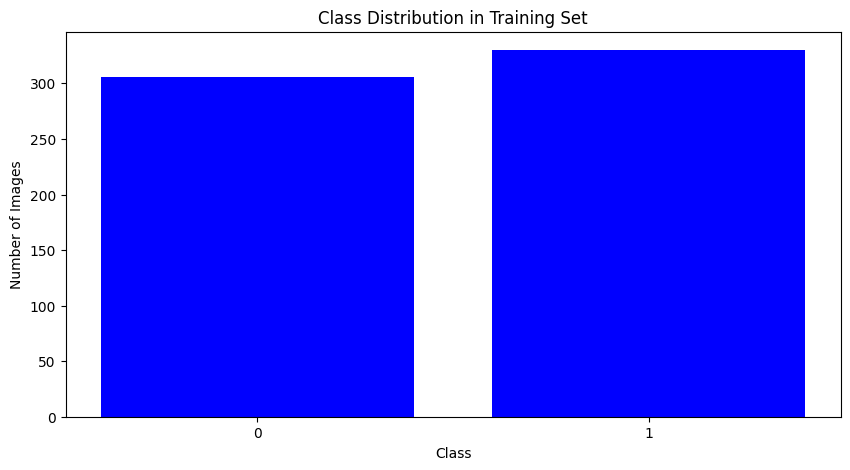

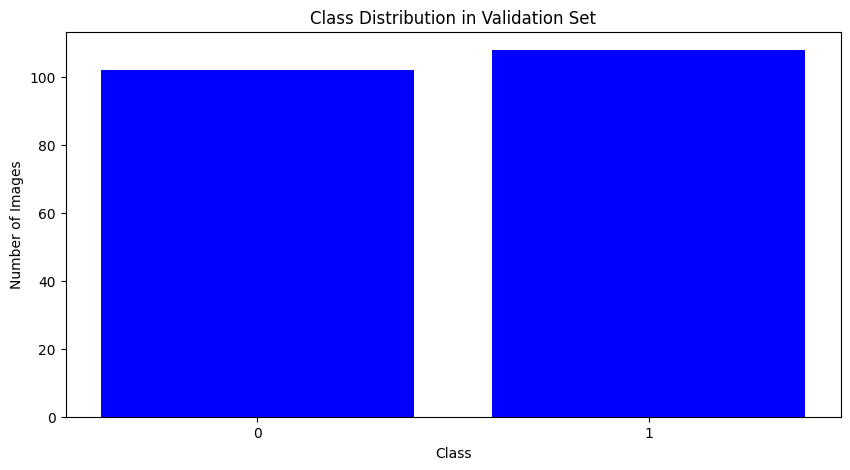

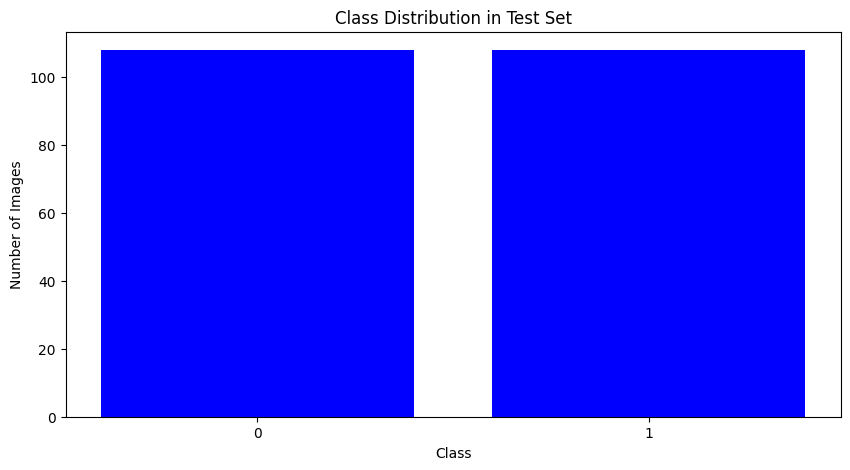

In [9]:
# Plot class distribution
def plot_class_distribution(counts, set_name):
    classes = list(counts.keys())
    values = list(counts.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, values, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.show()

plot_class_distribution(train_counts, 'Training')
plot_class_distribution(val_counts, 'Validation')
plot_class_distribution(test_counts, 'Test')

Display images

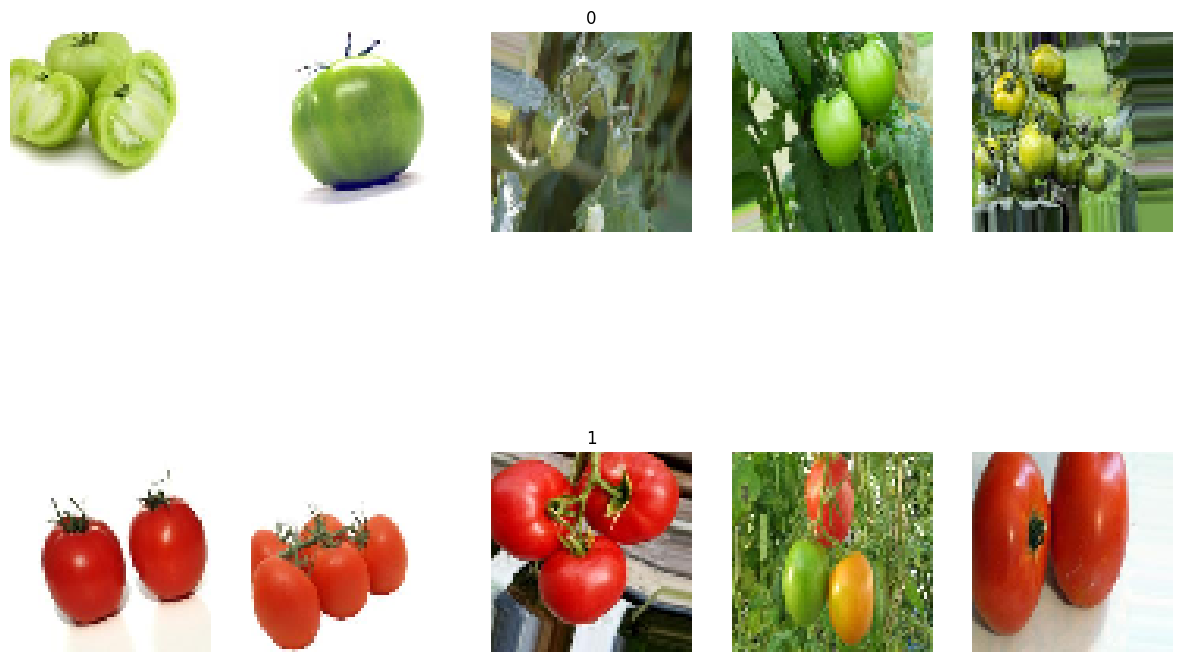

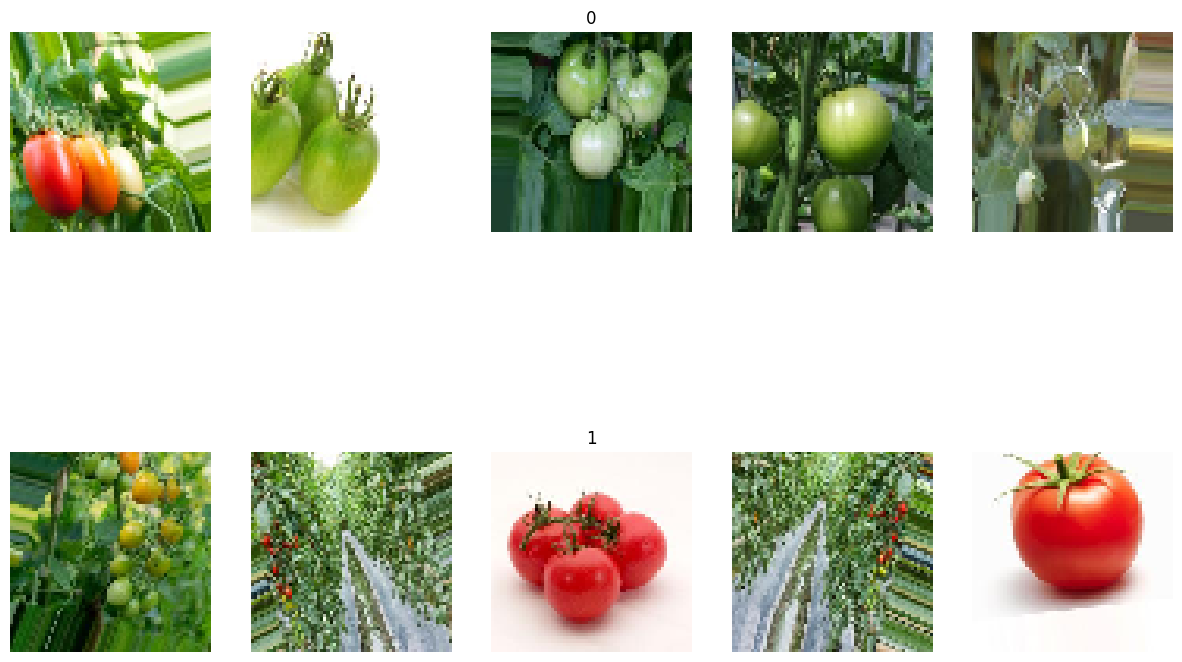

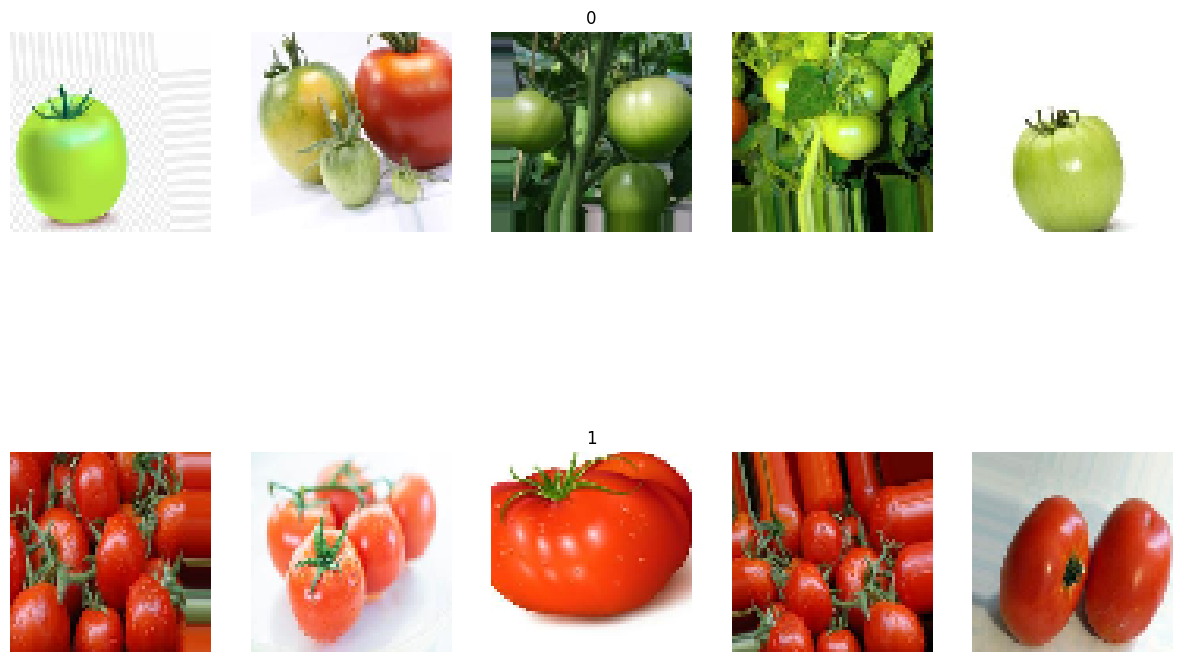

In [19]:
def display_image(directory, num_of_samples=5):
    # Get the list of class names (subdirectories) in the given directory
    classes = os.listdir(directory)

    # Set the size of the plot
    plt.figure(figsize=(15, 10))

    # Iterate over each class
    for i, class_name in enumerate(classes):
        # Construct the path to the current class directory
        class_path = os.path.join(directory, class_name)
        # Get a list of sample images in the current class directory (limit to num_of_samples)
        sample_images = os.listdir(class_path)[:num_of_samples]

        # Iterate over each sample image
        for j, img_name in enumerate(sample_images):
            # Construct the path to the current image file
            img_path = os.path.join(class_path, img_name)
            # Load the image and resize it to 64x64 pixels
            img = load_img(img_path, target_size=(64, 64))
            # Convert the image to a numpy array
            img_array = img_to_array(img)
            # Create a subplot for the current image
            plt.subplot(len(classes), num_of_samples, i * num_of_samples + j + 1)
            # Display the image
            plt.imshow(img_array.astype('uint8'))
            # Turn off the axis
            plt.axis('off')

            # If it's the middle image in the row, set the title to the class name
            if j == num_of_samples // 2:
                plt.title(class_name)

    # Display the plot
    plt.show()

# Display samples from the training set
display_image(train_dir)
# Display samples from the validation set
display_image(val_dir)
# Display samples from the test set
display_image(test_dir)


#Creating Dataset Variables

In [ ]:
# Define image size and batch size
image_size = (64, 64)
batch_size = 32

# Create an instance of ImageDataGenerator only for rescaling
data_gen = ImageDataGenerator(rescale=1./255)

generators

In [25]:
# Define image size and batch size
image_size = (64, 64)
batch_size = 32

# Create an instance of ImageDataGenerator only for rescaling
data_gen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print the class indices to verify
print("Class indices:", train_generator.class_indices)

Found 636 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Class indices: {'0': 0, '1': 1}


In [27]:
def load_data_from_generator(generator):
    data = []
    labels = []
    for _ in range(len(generator)):
        batch_data, batch_labels = generator.next()
        data.append(batch_data)
        labels.append(batch_labels)
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

In [26]:
# Load data into numpy arrays
X_train, y_train = load_data_from_generator(train_generator)
X_val, y_val = load_data_from_generator(val_generator)
X_test, y_test = load_data_from_generator(test_generator)

# Print the shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (636, 64, 64, 3)
y_train shape: (636, 2)
X_val shape: (210, 64, 64, 3)
y_val shape: (210, 2)
X_test shape: (216, 64, 64, 3)
y_test shape: (216, 2)


#Baseline Model

In [34]:
# Define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor: The metric to monitor during training.
    # In this case, it will monitor 'accuracy'.
    monitor='accuracy',

    # verbose: Controls the verbosity of the output.
    # With verbose=1, messages will be printed when training is stopped early.
    verbose=1,

    # patience: Number of epochs with no improvement after which training will be stopped.
    # Here, training will stop if there's no improvement in 'accuracy' for 4 consecutive epochs.
    patience=4,

    # mode: One of {'auto', 'min', 'max'}.
    # - 'min': training will stop when the quantity monitored has stopped decreasing.
    # - 'max': training will stop when the quantity monitored has stopped increasing.
    # - 'auto': mode is automatically inferred from the name of the monitored quantity.
    # Since we're monitoring 'accuracy', which we want to maximize, we use 'max'.
    mode='max',

    # restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity.
    # If True, the model weights obtained at the epoch with the best monitored value will be restored.
    restore_best_weights=True
)


In [41]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

baseline_model = tf.keras.Sequential()

baseline_model.add(tf.keras.layers.Conv2D(
    filters = 12,
    kernel_size = (3,3),
    strides = (1,1),
    padding = 'same',
    activation = 'relu',
    name = 'conv1',
    data_format='channels_last',
    input_shape = (64,64,3)
))

baseline_model.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2,2),
    name='max_pooling_1'
))

baseline_model.add(tf.keras.layers.Dropout(
    rate = 0.3,
    name = 'dropout_1'
))

baseline_model.add(tf.keras.layers.Flatten(
    name = 'flatten'
))

baseline_model.add(tf.keras.layers.Dense(
    units = 128,
    activation = 'relu',
    name = 'dense_1'
))

baseline_model.add(tf.keras.layers.Dense(
    units = 2,
    activation = 'softmax',
    name = 'dense_2'
))

baseline_model.build(input_shape = (None, 64, 64, 3))

baseline_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

baseline_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 12)        336       
                                                                 
 max_pooling_1 (MaxPooling2  (None, 32, 32, 12)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 12)        0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               1572992   
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                     

In [42]:
history = baseline_model.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_data=(X_val, y_val),  # Validation data and labels
    callbacks=[early_stopping]       # Callback for early stopping
)

# Evaluate the model on the training data
train_loss, train_accuracy = baseline_model.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch 1/20
20/20 [==============================] - 3s 99ms/step - loss: 49.3460 - accuracy: 0.5252 - val_loss: 0.6939 - val_accuracy: 0.5143
Epoch 2/20
20/20 [==============================] - 2s 125ms/step - loss: 0.6941 - accuracy: 0.4969 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 3/20
20/20 [==============================] - 2s 83ms/step - loss: 0.6929 - accuracy: 0.5220 - val_loss: 0.6961 - val_accuracy: 0.5143
Epoch 4/20
20/20 [==============================] - 1s 74ms/step - loss: 0.7056 - accuracy: 0.4308 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 5/20
20/20 [==============================] - 2s 85ms/step - loss: 0.6963 - accuracy: 0.5189 - val_loss: 0.6943 - val_accuracy: 0.5143
Epoch 5: early stopping
20/20 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.5189
Training loss: 0.6931836009025574, Training accuracy: 0.5188679099082947
7/7 [==============================] - 0s 24ms/step - loss: 0.6939 - accuracy: 0.5143
Validation loss: 0.693

Improving our model

In [43]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Conv2D(
    filters = 12,
    kernel_size = (3,3),
    strides = (1,1),
    padding = 'same',
    activation = 'relu',
    name = 'conv1',
    data_format='channels_last',
    input_shape = (64,64,3)
))

model1.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2,2),
    name='max_pooling_1'
))

model1.add(tf.keras.layers.Dropout(
    rate = 0.3,
    name = 'dropout_1'
))

model1.add(tf.keras.layers.Flatten(
    name = 'flatten'
))

model1.add(tf.keras.layers.Dense(
    units = 32,
    activation = 'relu',
    name = 'dense_1'
))

model1.add(tf.keras.layers.Dense(
    units = 128,
    activation = 'relu',
    name = 'dense_2'
))

model1.add(tf.keras.layers.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output'
))

model1.build(input_shape = (None, 64, 64, 3))

model1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 12)        336       
                                                                 
 max_pooling_1 (MaxPooling2  (None, 32, 32, 12)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 12)        0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                393248    
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                     

In [44]:
history = model1.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_data=(X_val, y_val),  # Validation data and labels
    callbacks=[early_stopping]       # Callback for early stopping
)

# Evaluate the model on the training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = model1.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch 1/20
20/20 [==============================] - 3s 111ms/step - loss: 0.5677 - accuracy: 0.7327 - val_loss: 0.3153 - val_accuracy: 0.9143
Epoch 2/20
20/20 [==============================] - 1s 65ms/step - loss: 0.2805 - accuracy: 0.8884 - val_loss: 0.2619 - val_accuracy: 0.9190
Epoch 3/20
20/20 [==============================] - 1s 68ms/step - loss: 0.2575 - accuracy: 0.9009 - val_loss: 0.2764 - val_accuracy: 0.9143
Epoch 4/20
20/20 [==============================] - 1s 67ms/step - loss: 0.1645 - accuracy: 0.9371 - val_loss: 0.2629 - val_accuracy: 0.9000
Epoch 5/20
20/20 [==============================] - 1s 67ms/step - loss: 0.1232 - accuracy: 0.9623 - val_loss: 0.2395 - val_accuracy: 0.9238
Epoch 6/20
20/20 [==============================] - 2s 86ms/step - loss: 0.1260 - accuracy: 0.9465 - val_loss: 0.2914 - val_accuracy: 0.9048
Epoch 7/20
20/20 [==============================] - 2s 113ms/step - loss: 0.0952 - accuracy: 0.9607 - val_loss: 0.2609 - val_accuracy: 0.9143
Epoch 8/20


#Baseline Stats

In [47]:
train_loss, train_accuracy = baseline_model.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")


20/20 [==============================] - 1s 38ms/step - loss: 0.6932 - accuracy: 0.5189
Training loss: 0.6931836009025574, Training accuracy: 0.5188679099082947
7/7 [==============================] - 0s 21ms/step - loss: 0.6961 - accuracy: 0.5000
Test loss: 0.6960642337799072, Test accuracy: 0.5
7/7 [==============================] - 0s 22ms/step - loss: 0.6939 - accuracy: 0.5143
Validation loss: 0.6938832402229309, Validation accuracy: 0.5142857432365417


#Model Stats

In [46]:
train_loss, train_accuracy = model1.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = model1.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")


20/20 [==============================] - 1s 37ms/step - loss: 0.0699 - accuracy: 0.9670
Training loss: 0.06991200149059296, Training accuracy: 0.9669811129570007
7/7 [==============================] - 0s 23ms/step - loss: 0.3968 - accuracy: 0.8796
Test loss: 0.3967597782611847, Test accuracy: 0.8796296119689941
7/7 [==============================] - 0s 20ms/step - loss: 0.2642 - accuracy: 0.9286
Validation loss: 0.26422473788261414, Validation accuracy: 0.9285714030265808
